# Práctica Final: Star Type Classification / NASA
<br><br><br>
 <div class="row">
  <div class="column">
    <img src="star.jpeg" alt="Snow" style="width:100%">
  </div>
</div> 
<br><br><br><br>

## Índice

- [Importación de librerías](#Importación-de-librerías)
- [Lectura de datos](#Lectura-de-datos)
- [Preprocesamiento](#Preprocesamiento)
    - [Análisis y eliminación de outliers](#Análisis-y-eliminación-de-outliers)
    - [Estandarización](#Estandarización)
    - [Imputación de valores perdidos](#Imputación-de-valores-perdidos)
    - [Codificación ordinal](#Codificación-ordinal)
- [Entrenamiento y validación de modelos](#Entrenamiento-y-validación-de-modelos)
    - [Resultados sin Estandarización ni detección de outliers](#Resultados-sin-Estandarización-ni-detección-de-outliers)
        - [KNN](#KNN)
        - [Árboles de Decisión](#Árboles-de-Decisión)
        - [Random Forest](#Random-Forest)
        - [Gráfica de resultados](#Gráfica-de-resultados)
    - [Resultados con Estandarización y detección de outliers](#Resultados-sin-Estandarización-ni-detección-de-outliers)
        - [KNN](#KNN)
        - [Árboles de Decisión](#Árboles-de-Decisión)
        - [Random Forest](#Random-Forest)
        - [Gráfica de resultados](#Gráfica-de-resultados)

# Importación de librerías

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, model_selection, neighbors,preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import tree as TREE
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

# Lectura de datos

Lectura de datos almacenados en el archivo Stars.csv. La variable a predecir se llama Type, que puede ser de seis tipos diferentes:
 <ul>
  <li>Red Dwarf - 0</li>
  <li>Brown Dwarf - 1</li>
  <li>White Dwarf - 2</li>
  <li>Main Sequence - 3</li>
  <li>Super Giants - 4</li> 
  <li>Hyper Giants - 5</li>
</ul> 

Existen 6 variables de entrada, 4 de ellas numéricas y las otras dos categóricas, a saber:
 <ul>
  <li>Temperatura: Temperatura media de la estrella en Kelvins (0 K  = -273,1 °C)</li>
  <li>L: Luminosidad de la estrella</li>
  <li>R: Radio de la estrella</li>
  <li>A-M: Magnitud absoluta de la estrella <href>https://es.wikipedia.org/wiki/Magnitud_absoluta</href></li>
  <li>Color: Color de la estrella</li> 
  <li>Spectral_Class: Clase espectral Morgan–Keenan (MK) <href>https://es.wikipedia.org/wiki/Clasificaci%C3%B3n_estelar</href></li>
</ul> 
<br>
La variable de salida tiene el nombre de *Type*

Vamos a generar las variables X (información de entrada) e y (información de salida).
</br>

In [2]:
import category_encoders as ce
stars = pd.read_csv('Stars.csv',na_values='NONE')

#División de variables
y =  stars.Type.copy()
X = stars.drop(['Type'], axis=1).copy()

#Nombre de variables
varEntrada = X.columns.values
varSalida = 'Type'

# Preprocesamiento

## Análisis y eliminación de outliers
Una vez leidos los datos, empezamos el preprocesamiento de los mismos. Para ello, vamos a analizar y eliminar posibles outliers 
en los datos.

Como se trata de un problema de clasificación, analizaremos los outliers por clases. Para ello, dividimos el dataframe por clases.


In [3]:
#Dividimos el dataFrame en clases
clase0 = X[stars['Type']==0]
clase1 = X[stars['Type']==1]
clase2 = X[stars['Type']==2]
clase3 = X[stars['Type']==3]
clase4 = X[stars['Type']==4]
clase5 = X[stars['Type']==5]


clases = [clase0,clase1,clase2,clase3,clase4,clase5]

Ahora vamos a mostrar graficamente los datos para poder visualizar mejor los outliers. Para ello, creamos la función *mostrarOutliers* que muestra un hisograma y un boxplot de cada variable.

In [4]:
def mostrarOutliers(X,i):
    X['Temperature']
    plt.figure(figsize=(16,10))
    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4)
    fig.suptitle('Clase ' + i)
    ax1.hist(X['Temperature'],bins=20)
    ax1.grid(True)
    ax2.hist(X['L'],bins=20)
    ax2.grid(True)
    ax3.hist(X['R'],bins=20)
    ax3.grid(True)
    ax4.hist(X['A_M'],bins=20)
    ax4.grid(True)
    ax5.boxplot(X['Temperature'])
    ax5.grid(True)
    ax6.boxplot(X['L'])
    ax6.grid(True)
    ax7.boxplot(X['R'])
    ax7.grid(True)
    ax8.boxplot(X['A_M'])
    ax8.grid(True)


Introducimos las clases en la función

<Figure size 1152x720 with 0 Axes>

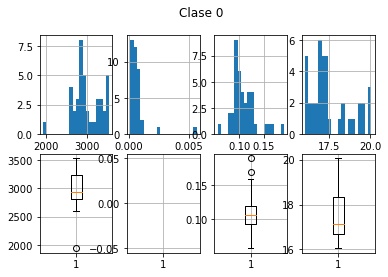

<Figure size 1152x720 with 0 Axes>

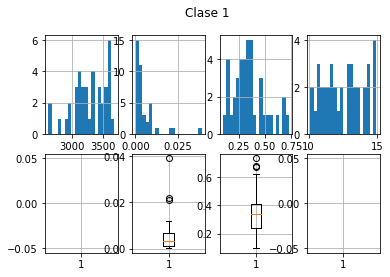

<Figure size 1152x720 with 0 Axes>

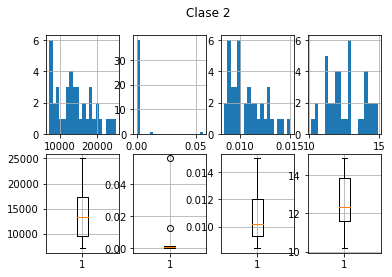

<Figure size 1152x720 with 0 Axes>

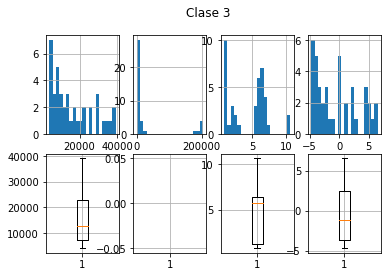

<Figure size 1152x720 with 0 Axes>

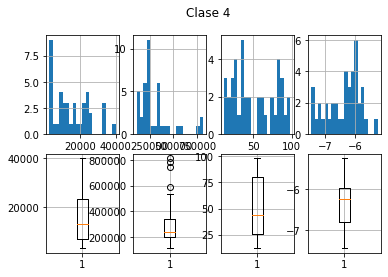

<Figure size 1152x720 with 0 Axes>

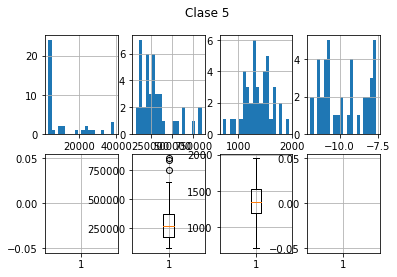

In [5]:
i=0
for clase in clases:
    mostrarOutliers(clase,str(i))
    i = i+1

Como podemos observar, exiten una serie de outliers por lo que vamos a proceder a eliminarlos. Para ello, hacemos uso de la función *deteccionOutliers_MeanStd*.

In [6]:
# Para calcular la media y la desviación debéis utilizar los métodos mean y std, respectivamente, y determinar el eje apropiado
def deteccionOutliers_MeanStd(dataFrame, k=1.5):
    mean = dataFrame.mean()
    std = dataFrame.std()
    return np.logical_or(dataFrame > mean + k * std, dataFrame < mean - k * std).any(1)

In [7]:
X_sinOut_ms = X.copy() #Inicilizamos las variables
y_sinOut_ms = y.copy() #Inicializamos la variable de salida

for clase in clases:
    # obtenemos el listado de booleanos que representa la presencia de outliers   
    outliers_ms= deteccionOutliers_MeanStd(clase.iloc[:,0:4], k=3) #lo hacemos solo para las variables numericas
    
    #Eliminamos los outliers hallados
    X_sinOut_ms = X_sinOut_ms.drop(index=outliers_ms[outliers_ms].index)
    y_sinOut_ms = y_sinOut_ms.drop(index=outliers_ms[outliers_ms].index)

In [8]:
#Podemos observar como, entre otros, el ejemplo 4 ha sido eliminado por un outlier en la variable temperatura
print(X) 
print(X_sinOut_ms)

     Temperature              L          R    A_M  Color Spectral_Class
0         3068.0       0.002400     0.1700  16.12    Red              M
1         3042.0       0.000500     0.1542  16.60    Red              M
2         2600.0            NaN     0.1020  18.70    Red              M
3         2800.0       0.000200     0.1600  16.65    Red              M
4         1939.0       0.000138     0.1030  20.06    Red              M
..           ...            ...        ...    ...    ...            ...
235      38940.0  374830.000000  1356.0000  -9.93   Blue              O
236          NaN  834042.000000  1194.0000 -10.63   Blue              O
237       8829.0  537493.000000  1423.0000 -10.73  White              A
238       9235.0  404940.000000  1112.0000 -11.23  White              A
239      37882.0  294903.000000  1783.0000  -7.80   Blue              O

[240 rows x 6 columns]
     Temperature             L          R    A_M  Color Spectral_Class
0         3068.0       0.00240     0.1700

## Estandarización
Una vez elimnados los outliers, procedemos a la estandarización de los datos. Para ello creamos la función *estandarizarDatos* para estandarizar datos tanto con outliers como sin ellos para, posteriormente, poder constatar la eficacia del preprocesamiento.

In [9]:
def estandarizarDatos(X):
    normalizarPorMedia = preprocessing.StandardScaler()
    datosEstandarizados = normalizarPorMedia.fit_transform(X.iloc[:,0:4])
    return pd.DataFrame(np.concatenate([datosEstandarizados,X.iloc[:,4:]],axis=1),columns=X.columns)

Ahora estandarizamos los datos con outliers y sin outliers por media y desviación estandar.

In [10]:
X_Est = estandarizarDatos(X)
X_sinOut_ms_Est = estandarizarDatos(X_sinOut_ms)

Mostramos ahora los histogramas y los bloxpots con los datos sin outliers

<Figure size 1152x720 with 0 Axes>

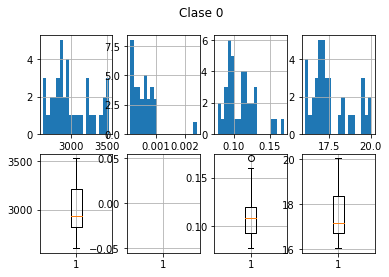

<Figure size 1152x720 with 0 Axes>

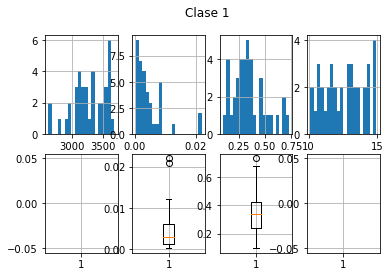

<Figure size 1152x720 with 0 Axes>

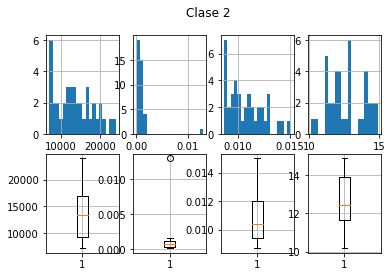

<Figure size 1152x720 with 0 Axes>

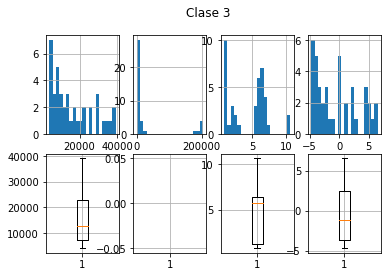

<Figure size 1152x720 with 0 Axes>

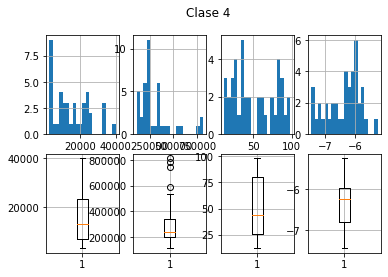

<Figure size 1152x720 with 0 Axes>

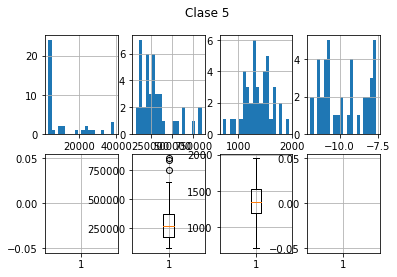

In [11]:
clase0_SinOutliers = X_sinOut_ms[y_sinOut_ms.values==0]
clase1_SinOutliers = X_sinOut_ms[y_sinOut_ms.values==1]
clase2_SinOutliers = X_sinOut_ms[y_sinOut_ms.values==2]
clase3_SinOutliers = X_sinOut_ms[y_sinOut_ms.values==3]
clase4_SinOutliers = X_sinOut_ms[y_sinOut_ms.values==4]
clase5_SinOutliers = X_sinOut_ms[y_sinOut_ms.values==5]

clases = [clase0_SinOutliers,clase1_SinOutliers,clase2_SinOutliers,clase3_SinOutliers,clase4_SinOutliers,clase5_SinOutliers]

i=0
for clase in clases:
    mostrarOutliers(clase,str(i))
    i = i+1

Podemos observar como varios outliers han sido eliminados con éxito.

## Imputación de valores perdidos
En el star.csv existen varios valores nulos (NONE). Analizamos los posibles valores perdidos de las variables e imputamos 
los nuevos valores mediante *SimpleImputer*

In [30]:
# Importamos las librerías SimpleImputer y ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Obtnemos las listas de variables categóricas y numéricas
nombres_variables_numericas = X_sinOut_ms_Est.dtypes != object
nombres_variables_categoricas = X_sinOut_ms_Est.dtypes == object

# Las variables numéricas las imputamos con la media y las categóricas con la moda: creamos el objeto de ColumnTransformer
t = [('num', SimpleImputer(strategy='mean'), nombres_variables_numericas), ('cat', SimpleImputer(strategy='most_frequent'), nombres_variables_categoricas)]
preprocesamiento = ColumnTransformer(transformers = t)

# Entrenamos e imputamos el método de preprocesamiento: imputación apropiada según el tipo de variable
# Lo hacemos tanto para los datos estandarizados como para los originales
X = preprocesamiento.fit_transform(X)
X_sinOut_ms_Est = preprocesamiento.fit_transform(X_sinOut_ms_Est)

Como el *ColumnTransformer* devuelve un array, lo convertimos en un dataframe mediante la siguente celda.

In [31]:
# Creamos un DataFrame a partir de stars_sin_missing
X = pd.DataFrame(X,columns=varEntrada)
X_sinOut_ms_Est = pd.DataFrame(X_sinOut_ms_Est,columns=varEntrada)

## Codificación ordinal
Realizamos ahora la división de las variables de entrada y salida y pasamos las variables categóricas a codificación ordinal

In [14]:
#Codificacion ordinal
myEncoder = ce.ordinal.OrdinalEncoder()
X[["Spectral_Class","Color"]] = myEncoder.fit_transform(X[["Spectral_Class","Color"]]) - 1

In [15]:
X_sinOut_ms_Est[["Spectral_Class","Color"]] = myEncoder.fit_transform(X_sinOut_ms_Est[["Spectral_Class","Color"]]) - 1

C:\Users\Alain\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


# Entrenamiento y validación de modelos
Vamos a entrenar los modelos con diferente algoritmos y configuraciones, y para cada algoritmo vamos a quedarnos con el que mejor resultados muestre.

Comenzamos por crear los conjuntos de train y test mediante *train_test_split* tanto para los datos originales como para los estandarizados limpios de outliers.

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y.values, train_size=0.65,random_state=12)

X_train_sinOut_Est, X_test_sinOut_Est, y_train_sinOut_Est, y_test_sinOut_Est = model_selection.train_test_split(
    X_sinOut_ms_Est, y_sinOut_ms.values, train_size=0.70,random_state=187)

In [17]:
def gridSearchKNN(X_,y_,tipoRendimiento):
    modeloReg = neighbors.KNeighborsClassifier()
    grid = {'n_neighbors': [1, 3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'p': [1, 2, 1.5, 3]}
    grid_search = model_selection.GridSearchCV(modeloReg,  grid, cv=10,scoring=tipoRendimiento)
    
    grid_search.fit(X_,y_)
    
    print("Medida Rendimiento \033[1m'",tipoRendimiento,'\033[0m :',grid_search.best_score_)
    print("Mejor configuracion encontrada: ",grid_search.best_params_)
    return grid_search

In [18]:
def gridSearchArbolDecision(X_train,y_train,tipoRendimiento):
    grid = {'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4]}
    grid_search = model_selection.GridSearchCV(TREE.DecisionTreeClassifier(),grid,cv=10,scoring=tipoRendimiento)

    grid_search.fit(X_train,y_train)
    
    print("Medida Rendimiento \033[1m'",tipoRendimiento,'\033[0m :',grid_search.best_score_)
    print("Mejor configuracion encontrada: ",grid_search.best_params_)
    return grid_search

In [19]:
def gridSearchRandomForest(X_train,y_train,tipoRendimiento):
    param_grid = {'n_estimators': [10,50],
                'max_depth': [5,10,None],
                'min_samples_split': [2,10]}

    grid_search = model_selection.GridSearchCV(RandomForestClassifier(),param_grid,scoring=tipoRendimiento,cv=10)
    grid_search.fit(X_train,y_train)    
    print("Medida Rendimiento \033[1m'",tipoRendimiento,'\033[0m :',grid_search.best_score_)
    print("Mejor configuracion encontrada: ",grid_search.best_params_)
    return grid_search

In [20]:
def getRendimientosTrainTest(X_train,y_train,X_test,y_test,clasificador):
    predTrain = clasificador.predict(X_train)
    accTrain = round(metrics.accuracy_score(y_train,predTrain)*100,2)
    print('El rendimiento en train es el {}%'.format(accTrain))

    ## En test usamos todos los ejemplos
    predTest = clasificador.predict(X_test)
    accTest = round(metrics.accuracy_score(y_test,predTest)*100,2)
    print('El rendimiento en test es {}%'.format(accTest),"\n")    
    return accTrain,accTest

## Resultados sin Estandarización ni detección de outliers

### KNN

In [21]:
listaScoring = ['precision_micro', 'recall_micro','accuracy','f1_micro','roc_auc_ovr']
rendimientoKNN = []

for scoring in listaScoring:
    knn = gridSearchKNN(X_train,y_train,scoring)
    rendimientoKNN.append(getRendimientosTrainTest(X_train,y_train,X_test,y_test,knn))

Medida Rendimiento ' precision_micro  : 0.7112499999999999
Mejor configuracion encontrada:  {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
El rendimiento en train es el 100.0%
El rendimiento en test es 71.43% 

Medida Rendimiento ' recall_micro  : 0.7112499999999999
Mejor configuracion encontrada:  {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
El rendimiento en train es el 100.0%
El rendimiento en test es 71.43% 

Medida Rendimiento ' accuracy  : 0.7112499999999999
Mejor configuracion encontrada:  {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
El rendimiento en train es el 100.0%
El rendimiento en test es 71.43% 

Medida Rendimiento ' f1_micro  : 0.7112499999999999
Mejor configuracion encontrada:  {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
El rendimiento en train es el 100.0%
El rendimiento en test es 71.43% 

Medida Rendimiento ' roc_auc_ovr  : 0.9363934676434678
Mejor configuracion encontrada:  {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
El rendimiento en train es 

### Árboles de Decisión 

In [22]:
rendimientoTree = []

for scoring in listaScoring:
    tree = gridSearchArbolDecision(X_train,y_train,scoring)
    rendimientoTree.append(getRendimientosTrainTest(X_train,y_train,X_test,y_test,tree))

Medida Rendimiento ' precision_micro  : 1.0
Mejor configuracion encontrada:  {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3}
El rendimiento en train es el 100.0%
El rendimiento en test es 98.81% 

Medida Rendimiento ' recall_micro  : 1.0
Mejor configuracion encontrada:  {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3}
El rendimiento en train es el 100.0%
El rendimiento en test es 100.0% 

Medida Rendimiento ' accuracy  : 1.0
Mejor configuracion encontrada:  {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2}
El rendimiento en train es el 100.0%
El rendimiento en test es 98.81% 

Medida Rendimiento ' f1_micro  : 1.0
Mejor configuracion encontrada:  {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2}
El rendimiento en train es el 100.0%
El rendimiento en test es 98.81% 

Medida Rendimiento ' roc_auc_ovr  : 1.0
Mejor configuracion encontrada:  {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 5}
El 

### Random Forest

In [23]:
rendimientoRF = []

for scoring in listaScoring:
    randomForest = gridSearchRandomForest(X_train,y_train,scoring)
    rendimientoRF.append(getRendimientosTrainTest(X_train,y_train,X_test,y_test,randomForest))

Medida Rendimiento ' precision_micro  : 1.0
Mejor configuracion encontrada:  {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 10}
El rendimiento en train es el 100.0%
El rendimiento en test es 98.81% 

Medida Rendimiento ' recall_micro  : 1.0
Mejor configuracion encontrada:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
El rendimiento en train es el 100.0%
El rendimiento en test es 98.81% 

Medida Rendimiento ' accuracy  : 1.0
Mejor configuracion encontrada:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
El rendimiento en train es el 100.0%
El rendimiento en test es 100.0% 

Medida Rendimiento ' f1_micro  : 1.0
Mejor configuracion encontrada:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
El rendimiento en train es el 100.0%
El rendimiento en test es 98.81% 

Medida Rendimiento ' roc_auc_ovr  : 1.0
Mejor configuracion encontrada:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
El rendimiento en train es el 100.0%
El re

### Gráfica de resultados
Mostramos una gráfica con los resultados de cada método

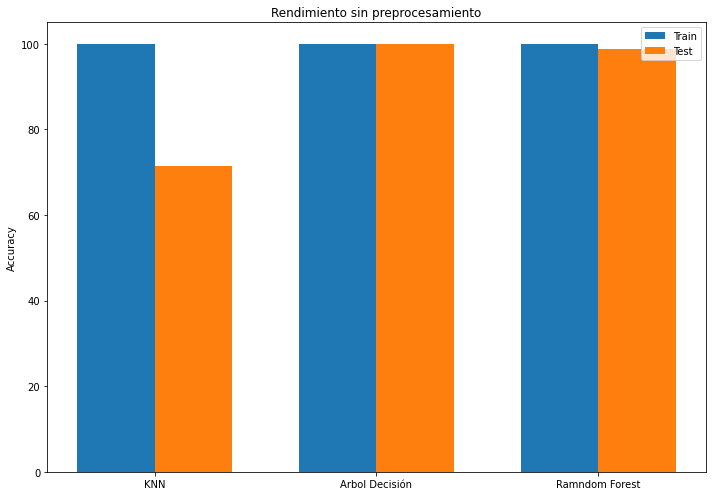

In [24]:
labels = ['KNN', 'Arbol Decisión', 'Ramndom Forest']
accTrain = [rendimientoKNN[1][0],rendimientoTree[1][0],rendimientoRF[1][0]]
accTest = [rendimientoKNN[1][1], rendimientoTree[1][1],rendimientoRF[1][1]]

x = np.arange(len(labels))  
width = 0.35

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, accTrain, width, label='Train')
rects2 = ax.bar(x + width/2, accTest, width, label='Test')

ax.set_ylabel('Accuracy')
ax.set_title('Rendimiento sin preprocesamiento')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

# Resultados con Estandarización y detección de outliers

### KNN

In [25]:
listaScoring = ['precision_micro', 'recall_micro','accuracy','f1_micro','roc_auc_ovr']
rendimientoKNN = []

for scoring in listaScoring:
    knn = gridSearchKNN(X_train_sinOut_Est,y_train_sinOut_Est,scoring)
    rendimientoKNN.append(getRendimientosTrainTest(X_train_sinOut_Est,y_train_sinOut_Est,X_test_sinOut_Est,y_test_sinOut_Est,knn))

Medida Rendimiento ' precision_micro  : 0.9878676470588236
Mejor configuracion encontrada:  {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
El rendimiento en train es el 100.0%
El rendimiento en test es 95.77% 

Medida Rendimiento ' recall_micro  : 0.9878676470588236
Mejor configuracion encontrada:  {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
El rendimiento en train es el 100.0%
El rendimiento en test es 95.77% 

Medida Rendimiento ' accuracy  : 0.9878676470588236
Mejor configuracion encontrada:  {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
El rendimiento en train es el 100.0%
El rendimiento en test es 95.77% 

Medida Rendimiento ' f1_micro  : 0.9878676470588236
Mejor configuracion encontrada:  {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
El rendimiento en train es el 100.0%
El rendimiento en test es 95.77% 

Medida Rendimiento ' roc_auc_ovr  : 0.9938492063492064
Mejor configuracion encontrada:  {'n_neighbors': 5, 'p': 1.5, 'weights': 'distance'}
El rendimiento en train e

### Arboles de Decisión

In [26]:
rendimientoTree = []

for scoring in listaScoring:
    tree = gridSearchArbolDecision(X_train_sinOut_Est,y_train_sinOut_Est,scoring)
    rendimientoTree.append(getRendimientosTrainTest(X_train_sinOut_Est,y_train_sinOut_Est,X_test_sinOut_Est,y_test_sinOut_Est,tree))

Medida Rendimiento ' precision_micro  : 1.0
Mejor configuracion encontrada:  {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2}
El rendimiento en train es el 100.0%
El rendimiento en test es 97.18% 

Medida Rendimiento ' recall_micro  : 1.0
Mejor configuracion encontrada:  {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 15}
El rendimiento en train es el 100.0%
El rendimiento en test es 95.77% 

Medida Rendimiento ' accuracy  : 1.0
Mejor configuracion encontrada:  {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 15}
El rendimiento en train es el 100.0%
El rendimiento en test es 97.18% 

Medida Rendimiento ' f1_micro  : 1.0
Mejor configuracion encontrada:  {'criterion': 'gini', 'min_samples_leaf': 4, 'min_samples_split': 5}
El rendimiento en train es el 100.0%
El rendimiento en test es 97.18% 

Medida Rendimiento ' roc_auc_ovr  : 1.0
Mejor configuracion encontrada:  {'criterion': 'entropy', 'min_samples_leaf': 4, 'min_samples_split'

### Random Forest

In [27]:
rendimientoRF = []

for scoring in listaScoring:
    randomForest = gridSearchRandomForest(X_train_sinOut_Est,y_train_sinOut_Est,scoring)
    rendimientoRF.append(getRendimientosTrainTest(X_train_sinOut_Est,y_train_sinOut_Est,X_test_sinOut_Est,y_test_sinOut_Est,randomForest))

Medida Rendimiento ' precision_micro  : 1.0
Mejor configuracion encontrada:  {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
El rendimiento en train es el 100.0%
El rendimiento en test es 100.0% 

Medida Rendimiento ' recall_micro  : 1.0
Mejor configuracion encontrada:  {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
El rendimiento en train es el 100.0%
El rendimiento en test es 100.0% 

Medida Rendimiento ' accuracy  : 1.0
Mejor configuracion encontrada:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
El rendimiento en train es el 100.0%
El rendimiento en test es 100.0% 

Medida Rendimiento ' f1_micro  : 1.0
Mejor configuracion encontrada:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
El rendimiento en train es el 100.0%
El rendimiento en test es 97.18% 

Medida Rendimiento ' roc_auc_ovr  : 1.0
Mejor configuracion encontrada:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
El rendimiento en train es el 100.0%
El r

### Gráfica de resultados
Mostramos una gráfica con los resultados de cada método

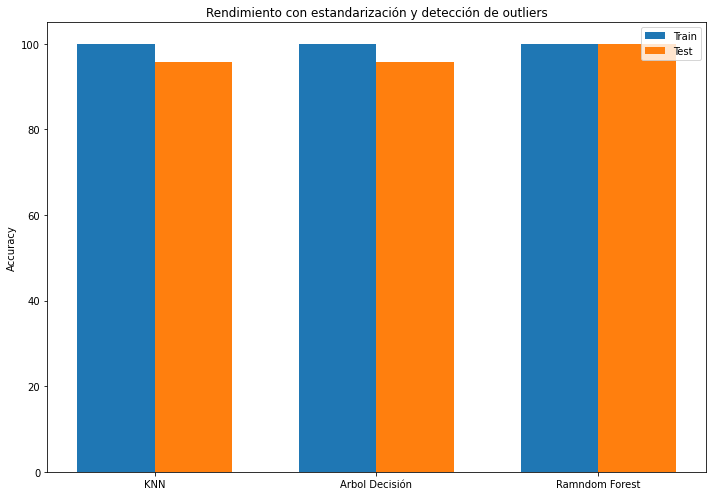

In [28]:
labels = ['KNN', 'Arbol Decisión', 'Ramndom Forest']
accTrain = [rendimientoKNN[1][0],rendimientoTree[1][0],rendimientoRF[1][0]]
accTest = [rendimientoKNN[1][1], rendimientoTree[1][1],rendimientoRF[1][1]]

x = np.arange(len(labels))  
width = 0.35

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, accTrain, width, label='Train')
rects2 = ax.bar(x + width/2, accTest, width, label='Test')

ax.set_ylabel('Accuracy')
ax.set_title('Rendimiento con estandarización y detección de outliers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()